In [1]:
"ATROUS FCN. NO_DOWNSAMPLING"

'ATROUS FCN. NO_DOWNSAMPLING'

In [2]:
# importing the necessary libraries and dependencies
""""adapted/improved from the original code developed in Bergado, J. R. A., Persello, C., & Gevaert, C. (2016). 
    A deep learning approach to the classification of sub-decimeter resolution aerial images.
    In IEEE International Geoscience and Remote Sensing Symposium (pp. 1516–1519). Beijing."""

'"adapted/improved from the original code developed in Bergado, J. R. A., Persello, C., & Gevaert, C. (2016). \n    A deep learning approach to the classification of sub-decimeter resolution aerial images.\n    In IEEE International Geoscience and Remote Sensing Symposium (pp. 1516\xe2\x80\x931519). Beijing.'

In [3]:
from numpy.random import seed,randint
import time
import keras
import numpy as np
import h5py
from keras.models import Sequential, Model
from keras.layers import Input, Lambda,LeakyReLU
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Add
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Dropout,Concatenate
from keras.callbacks import LearningRateScheduler
#from keras.preprocessing import image, datagen
from keras.optimizers import SGD,Adam
import theano.tensor as T
from keras import backend as K
from theano import ifelse
import matplotlib.pyplot as plt
seed(352)
K.set_image_dim_ordering("th")
t0 = time.time()

nb_epoch = 100
batch_size = 128
nc = 5

_epsilon = 1e-6

Using Theano backend.
Using cuDNN version 7005 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:05:00.0)


In [ ]:
# defining the functions

In [4]:
#customize the softmax activation function
def softmax_4d(softmax_input):
    """Elementwise softmax for 4d tensors."""
    si = softmax_input.reshape((softmax_input.shape[0],
                                softmax_input.shape[1], -1))
    shp = (si.shape[0], 1, si.shape[2])
    exp = K.exp(si - si.max(axis=1).reshape(shp))
    out = (exp / exp.sum(axis=1).reshape(shp)).reshape(softmax_input.shape)
    return out

#customize the loss function
   
def categorical_CE2D(y_true, y_pred):
    y_pred = K.clip(y_pred, _epsilon, 1.0 - _epsilon)
    cce = K.mean(-K.sum(y_true*K.log(y_pred), axis=[1]))
    return cce

def categorical_accuracy2D(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1),
                  K.argmax(y_pred, axis=1)))
				  
def to_categorical_4d(y, nc):
    """Convert a reclassed ground truth array to one-hot encoding
    
    Keyword arguments:
    y -- ground truth image
    nc -- number of classes
    """
    Y = np.zeros((y.shape[0],
                  nc,
                  y.shape[2],
                  y.shape[3]),
                  dtype=np.int32)
    y=y.astype(np.int32)
    
    for h in range(y.shape[0]):
        for i in range(y.shape[2]):
            for j in range(y.shape[3]):
                
                if y[h, 0, i, j] != 0:
                    Y[h, y[h, 0, i, j]-1, i, j] = 1
                else:
                    continue
    
    return Y

"""
#BN followed by RELU
def add_common_layers(y):
    y = BatchNormalization(axis=1)(y) #should i define the axis for BN? what is the effect of not specifying the BN
    #y = Activation ('relu')(y)
    y=LeakyReLU(alpha=0.1)(y)
    y=Dropout(0.5)(y)
    return y
"""
def add_common_layers(y):
    y = Activation ('relu')(y)
    #y=LeakyReLU(alpha=0.1)(y)
    y = BatchNormalization(axis=1)(y) #should i define the axis for BN? what is the effect of not specifying the BN
    #y = Activation ('relu')(y)
    #y=Dropout(0.2)(y)
    return y

def block_1(inpt):
	x = inpt
	x_0 = ZeroPadding2D((4, 4))(x)
	x_0 = Conv2D(64, (5, 5), padding = 'valid', dilation_rate = (2,2))(x_0)
	x_0 = add_common_layers(x_0)
	x_0 = ZeroPadding2D((1, 1))(x_0)
	x_0 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_0)
	return x_0

def block_2(inp):
	x_1 = inp
	x_2 = ZeroPadding2D((2, 2))(x_1)
	x_2 = Conv2D(64, (3, 3), padding = 'valid', dilation_rate = (2,2))(x_2)
	x_2 = add_common_layers(x_2)
	x_2 = ZeroPadding2D((1, 1))(x_2)
	x_2 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_2)
	return x_2

"""
#vanilla fcn, using normal convolutional neural networks
def block_1(inpt):
	x = inpt
	x_0 = ZeroPadding2D((2, 2))(x)
	x_0 = Conv2D(64, (5, 5), padding = 'valid')(x_0)
	x_0 = add_common_layers(x_0)
	x_0 = ZeroPadding2D((1, 1))(x_0)
	x_0 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_0)
	return x_0
	
def block_2(inp):
	x_1 = inp
	x_2 = ZeroPadding2D((1, 1))(x_1)
	x_2 = Conv2D(64, (3, 3), padding = 'valid')(x_2)
	x_2 = add_common_layers(x_2)
	x_2 = ZeroPadding2D((1, 1))(x_2)
	x_2 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_2)
	return x_2
"""


"\n#vanilla fcn, using normal convolutional neural networks\ndef block_1(inpt):\n\tx = inpt\n\tx_0 = ZeroPadding2D((2, 2))(x)\n\tx_0 = Conv2D(64, (5, 5), padding = 'valid')(x_0)\n\tx_0 = add_common_layers(x_0)\n\tx_0 = ZeroPadding2D((1, 1))(x_0)\n\tx_0 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_0)\n\treturn x_0\n\t\ndef block_2(inp):\n\tx_1 = inp\n\tx_2 = ZeroPadding2D((1, 1))(x_1)\n\tx_2 = Conv2D(64, (3, 3), padding = 'valid')(x_2)\n\tx_2 = add_common_layers(x_2)\n\tx_2 = ZeroPadding2D((1, 1))(x_2)\n\tx_2 = MaxPooling2D(pool_size=(3, 3),strides=1)(x_2)\n\treturn x_2\n"

In [5]:
#function for the learning rate scheduling
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        #return initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        if epoch<50:
            return 0.1
        else:
            return 0.001
        
    
    return LearningRateScheduler(schedule)

  

In [6]:
"adding path to the new dataset"
datadir = "H:/BUKAVU-2018/PRELIM_CNN/"
#smpldir = datadir + "samples/samples_gray_v3.hdf5"
#smpldir= datadir + "samples/samples_weakly_geobia2.hdf5"
tutorialdir = "H:/tutorial_fcn/"
smpldir= tutorialdir  + "samples/samples_wfcn_v1.hdf5"

In [7]:
"reading the data"
with h5py.File(smpldir, "r") as f:
	x_train = np.asarray(f["X_train"])
	x_val = np.asarray(f["X_val"])
	#x_test = np.asarray(f["X_test"])
	y_train = np.asarray(f["y_train"])
	y_val = np.asarray(f["y_val"])
	#y_test = np.asarray(f["y_test"])

In [8]:
# IMPORTANT: labels should be from 1 to # of classes (zero-labels are considered unlabeled)

y_train = y_train + 1
y_val = y_val + 1

y_train = to_categorical_4d(y_train, nc)
y_val = to_categorical_4d(y_val, nc)

In [9]:
"definition of the fcn network"
#apparently the merge operations with the exception of the concatenate need tensors of same dimensions
psize = 33
inp = Input(shape=(3, psize, psize))

x0=block_1(inp)
x1=block_1(x0)
x2=block_2(x1)
x3=block_2(x2)
x4=block_2(x3)
x5=block_2(x4)
x6=block_2(x5)
#x6=block_1(x3)
"concatenation layer"
#xc6= Concatenate(axis = 1)([x0,x1,x2,x3,x4])
xc6= Concatenate(axis = 1)([x0,x1,x2,x3,x4,x5,x6])
#x6_m = Add()([x1,x6])

x7=Conv2D(5, (1, 1))(xc6)

#adding the softmax activation
out_p = Activation(softmax_4d)(x7)

#create the model 

model = Model(input=inp,output=out_p)


#sgd = SGD (lr = 0.1, decay = 0.001, momentum = 0.5, nesterov = True)
#○adm= Adam(lr=0.01,beta_1=0.9,beta_2=0.999,epsilon = None, decay = 0.0)
sgd = SGD (momentum = 0.9, nesterov = True)
model.compile(optimizer=sgd, loss=categorical_CE2D,
                    metrics=[categorical_accuracy2D])

C:\Users\Nicholus\AppData\Local\conda\conda\envs\env_name27\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{4}..., inputs=/input_1)`


In [10]:
"train the model and save the weights"
t0 = time.time()
lr_sched = step_decay_schedule(initial_lr=1e-1, decay_factor=0.75, step_size=2)

history = model.fit(x_train,y_train,
                          validation_data=(x_val, y_val),shuffle = True,
                          epochs=nb_epoch, batch_size=batch_size,callbacks=[lr_sched], verbose=0)

t1 = time.time()
print("Finished training after %.2f mins" % ((t1-t0)/60.0))
w8fname = tutorialdir+\
          "weights/fcn_weakly_geobia3.hdf5"
model.save_weights(w8fname, overwrite=True)

Finished training after 15.01 mins


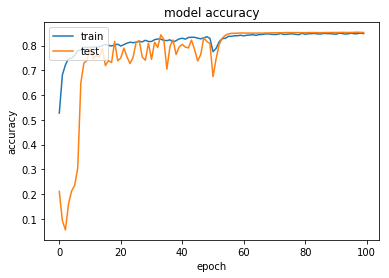

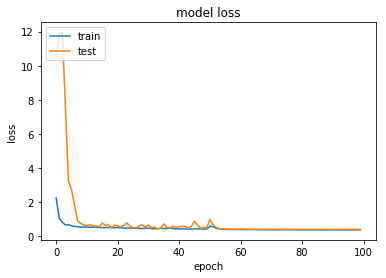

In [11]:
"visualize the learned weights"

#summarize history for accuracy

plt.plot(history.history['categorical_accuracy2D'])
plt.plot(history.history['val_categorical_accuracy2D'])
plt.title('model accuracy')
plt.ylabel ('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
